## Tutorial of Interchange Intervention / Activation Patching

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/basic_tutorials/Basic_Intervention.ipynb)

In [1]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.

### Set-up

In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [2]:
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall

In [5]:
config, tokenizer, gpt = pyvene.create_gpt2(
    cache_dir='/home/jovyan/.cache/huggingface/hub')

base = "The capital of Spain is"
source = "The capital of Italy is"

inputs = [tokenizer(base, return_tensors="pt"),
          tokenizer(source, return_tensors="pt")]

loaded model


In [14]:
"""

def embed_to_distrib(model, embed, log=False, logits=False):
    # Converts an embedding to a distribution over the vocabulary

    if "gpt2" in model.config.architectures[0].lower():
        with torch.inference_mode():
            vocab = torch.matmul(embed, model.wte.weight.t())
            if logits:
                return vocab
            # lsm is logsoftmax and sm is softmax...
            return lsm(vocab) if log else sm(vocab)
    elif "llama" in model.config.architectures[0].lower():
        assert False, "Support for LLaMA is not here yet"

"""
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
_Madrid              0.10501234978437424
_the                 0.0949699655175209
_Barcelona           0.0702790841460228
_a                   0.04010068252682686
_now                 0.02824278175830841
_in                  0.02759990654885769
_Spain               0.022991720587015152
_Catalonia           0.018823225051164627
_also                0.018689140677452087
_not                 0.01735665090382099


In [22]:
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)


The capital of Italy is
_Rome                0.15734916925430298
_the                 0.07316355407238007
_Milan               0.046878915280103683
_a                   0.03449810668826103
_now                 0.03200329467654228
_in                  0.02306535840034485
_also                0.02274816483259201
_home                0.01920313946902752
_not                 0.01640527881681919
_Italy               0.01577090471982956


### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [24]:
def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [25]:
tokens = tokenizer.encode(" Madrid Rome")

In [31]:
# should finish within 1 min with a standard 12G GPU
data = []
# gpt2 has 12 layers. for each of them:
for layer_i in range(gpt.config.n_layer):

    # create an intervention configuration:
    config = simple_position_config(type(gpt), "mlp_output", layer_i)
    # create an intervenable model
    intervenable = IntervenableModel(config, gpt)

    # for each token in the base input.
    for pos_i in range(len(base.input_ids[0])):

        # perform intervention taken the corresponing token from the source
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )

        # get the softmaxed output probs from the vocab.
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )

        # save results
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    # do the same for the attention layer...
    config = simple_position_config(type(gpt), "attention_input", layer_i)
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)

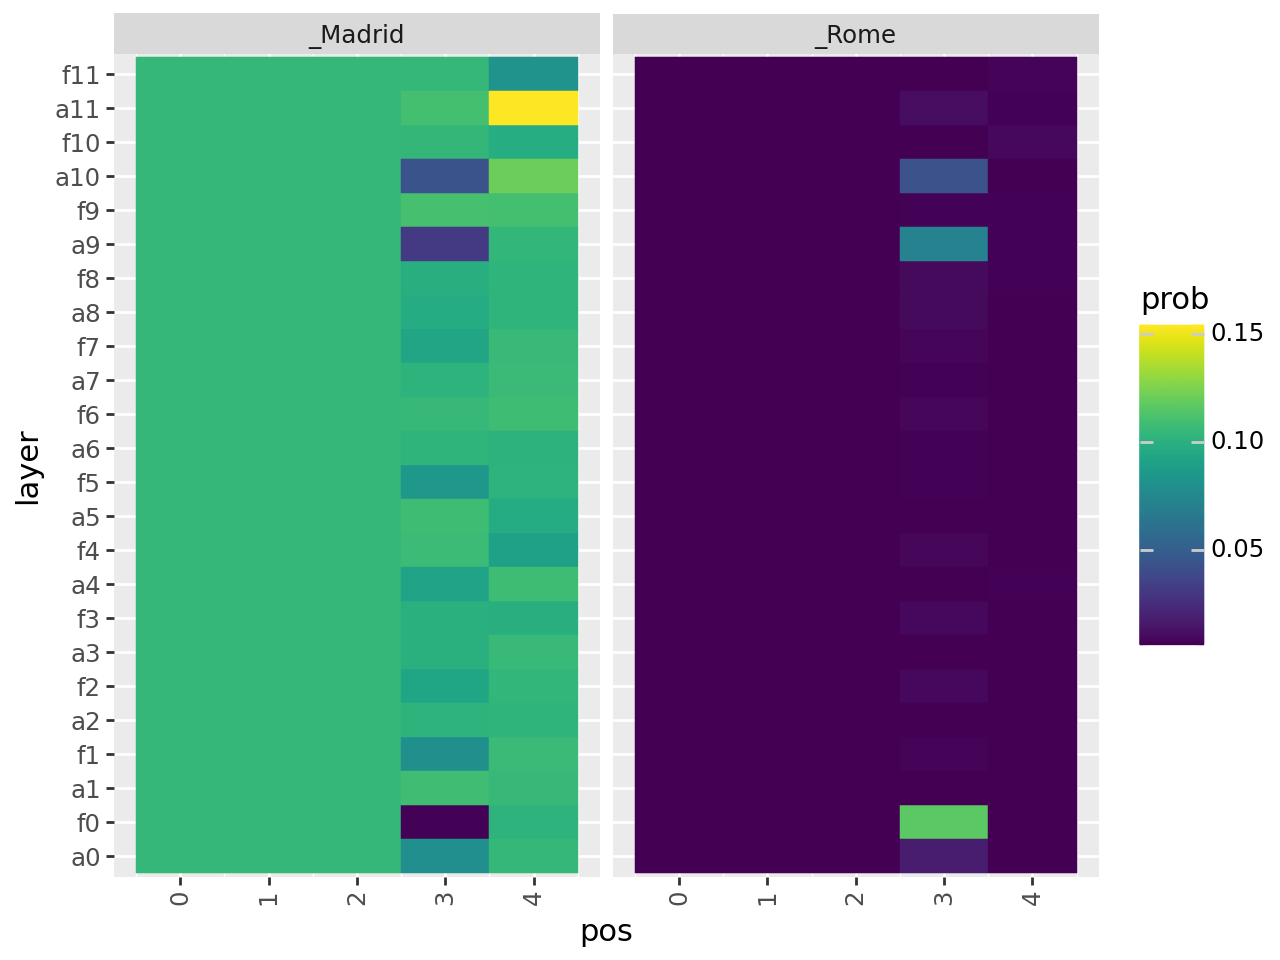

In [35]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []

for layer in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"f{layer}")
    nodes.append(f"a{layer}")

df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
g.show()

In [43]:
df['pos'].max()

4

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


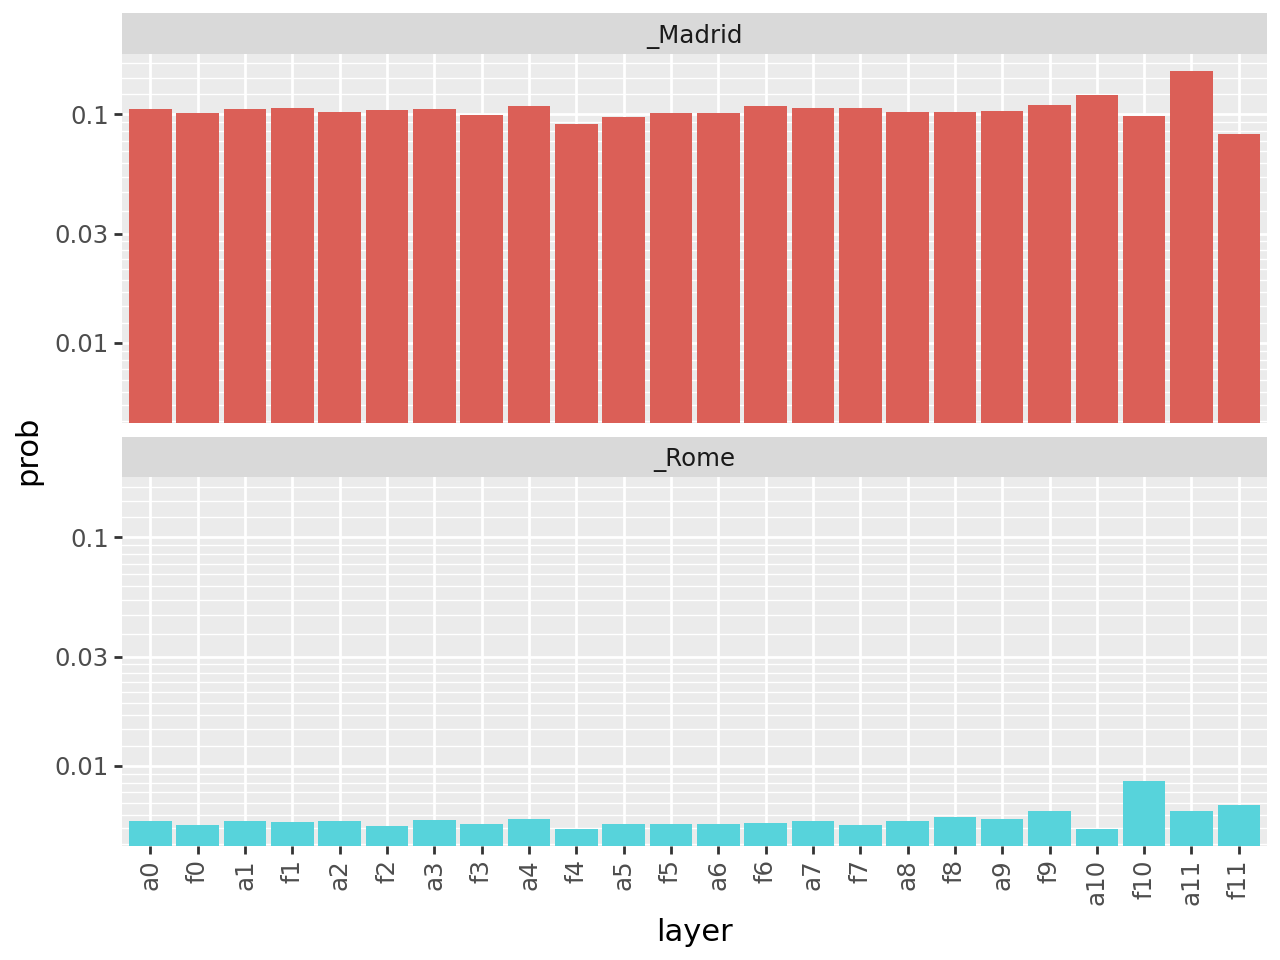

In [40]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
g.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


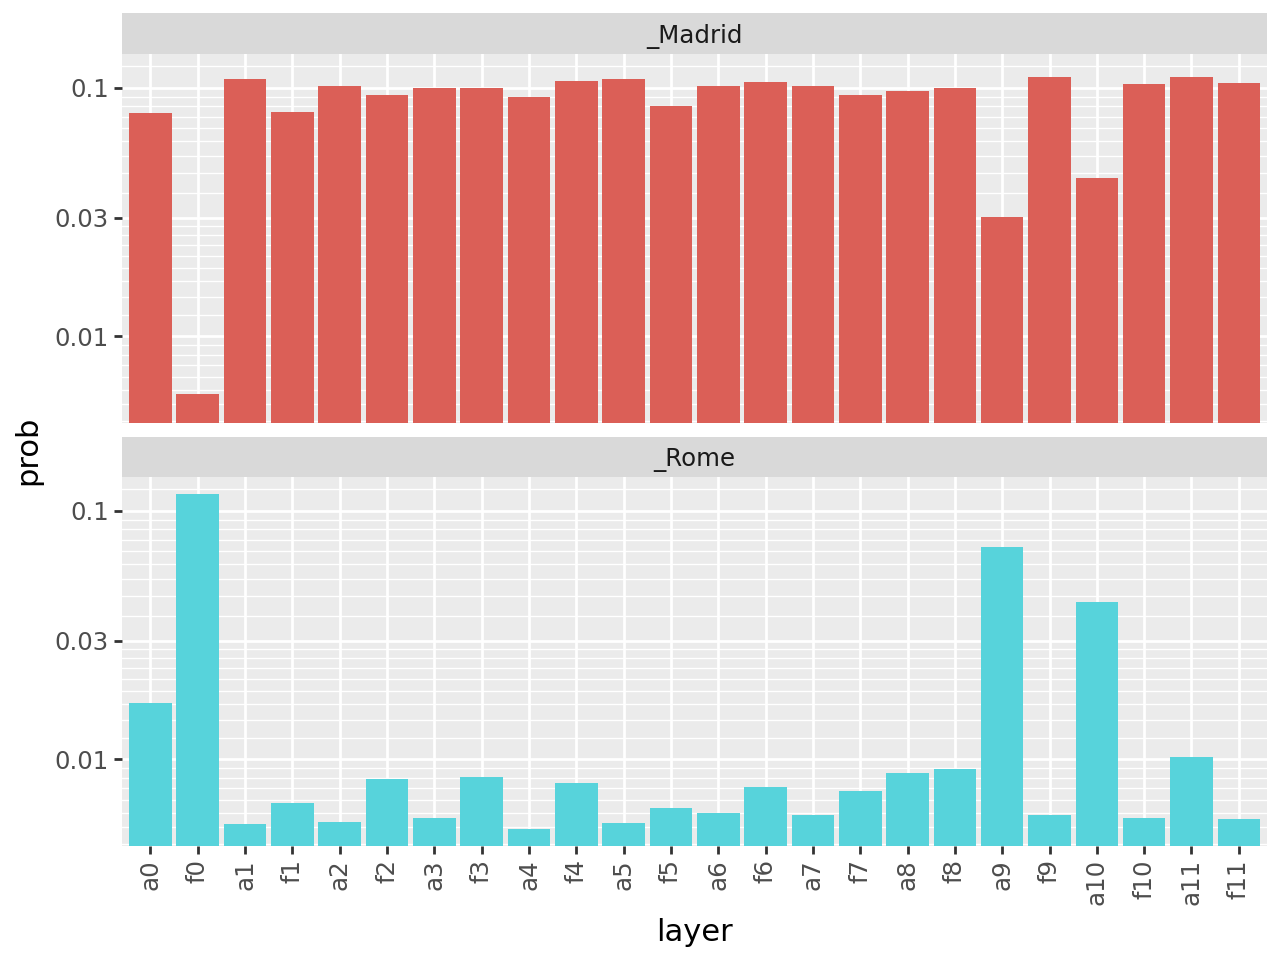

In [44]:
filtered = df
filtered = filtered[filtered["pos"] == 3]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
g.show()